# 12. 트랜스포머로 만드는 대화형 챗봇

**트랜스포머의 인코더 디코더 구조와 셀프 어텐션을 코드를 통해 이해해 본다. 이를 영어와 한국어로 이루어진 챗봇 데이터에 적용해 본다.**

## 12-14. 프로젝트: 한국어 데이터로 챗봇 만들기

영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

---

### 목차
- Step 1. 데이터 수집하기
- Step 2. 데이터 전처리하기
- Step 3. SubwordTextEncoder 사용하기
- Step 4. 모델 구성하기
- Step 5. 모델 평가하기

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("슝=3")

슝=3


### Step 1. 데이터 수집하기
- 송영숙님이 공개한 한국어 챗봇 데이터: [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
    - 질문에 챗봇이 위로한다는 취지로 답변을 작성
    - 챗봇 트레이닝용 문답 페이 11,823개
    - 일상다반사(중립) 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
      - 중립 0: 5290개
      - 부정 1: 3570개
      - 긍정 2: 2963개
    - 결측치 없음

#### 데이터 불러오기

In [3]:
csv_path = 'drive/MyDrive/Colab Notebooks/transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(csv_path)
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [4]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


#### 데이터 확인

In [5]:
# 질문(Q)
data['Q'].values[0]

'12시 땡!'

In [6]:
# 답변(A)
data['A'].values[0]

'하루가 또 가네요.'

In [7]:
# 감정(label): 중립 0, 부정 1, 긍정 2 레이블링
data['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

In [8]:
# 결측치 확인
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

### Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

- 전처리 함수
    - 정규 표현식으로 구두점 제거 => 단어 토크나이징 방해되지 않게 정제하는 기능

In [9]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


- 데이터 로드 함수
    - 데이터 로드와 동시에 문답 페이 전처리 진행

In [10]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  inputs, outputs = [], []
  for i in range(MAX_SAMPLES):
    # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
    inputs.append(preprocess_sentence(data['Q'].values[i]))
    outputs.append(preprocess_sentence(data['A'].values[i]))

  return inputs, outputs

print("슝=3")

슝=3


In [11]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [12]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 `SubwordTextEncoder`를 그대로 사용해보세요.

#### 1. 단어장(Vocabulary) 만들기

In [13]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [14]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [15]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [16]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8129


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [17]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5742, 612, 2481, 4148]
정수 인코딩 후의 21번째 답변 샘플: [2352, 7481, 7, 6245, 97, 1]


In [18]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [19]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [20]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


#### 3. 교사 강요(Teacher Forcing) 사용하기

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


### Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

- 포지셔널 행렬 구하기
  - 트랜스포머는 사인 함수, 코사인 함수 값을 임베딩 벡터에 더함(=단어의 순서 정보를 더함)
  - 트랜스포머는 문장 단위로 입력받기 때문에 어순 정보가 필요하다.

In [22]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


- 어텐션

In [23]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [24]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


- 마스킹

In [25]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [26]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [27]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


- 인코더

In [28]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


- 디코더

In [29]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [30]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


- 트랜스포머 함수 정의

In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


- 모델 생성

In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3135232     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 손실 함수

In [33]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


- 커스텀 학습률

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

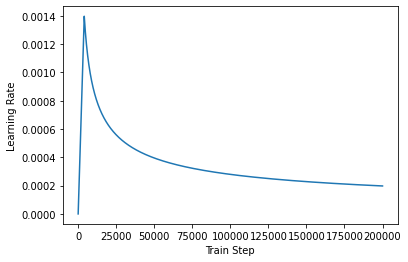

In [35]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

- 모델 컴파일

In [36]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


- 모델 훈련

In [37]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 17s 58ms/step - loss: 1.4580 - accuracy: 0.0197
Epoch 2/20
185/185 [==============================] - 11s 58ms/step - loss: 1.1818 - accuracy: 0.0492
Epoch 3/20
185/185 [==============================] - 11s 58ms/step - loss: 1.0052 - accuracy: 0.0506
Epoch 4/20
185/185 [==============================] - 11s 59ms/step - loss: 0.9278 - accuracy: 0.0543
Epoch 5/20
185/185 [==============================] - 11s 58ms/step - loss: 0.8697 - accuracy: 0.0575
Epoch 6/20
185/185 [==============================] - 11s 58ms/step - loss: 0.8094 - accuracy: 0.0617
Epoch 7/20
185/185 [==============================] - 11s 58ms/step - loss: 0.7428 - accuracy: 0.0678
Epoch 8/20
185/185 [==============================] - 11s 58ms/step - loss: 0.6689 - accuracy: 0.0757
Epoch 9/20
185/185 [==============================] - 11s 58ms/step - loss: 0.5903 - accuracy: 0.0844
Epoch 10/20
185/185 [==============================] - 11s 58ms/step - loss: 0.508

### Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [38]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [39]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


- 모델 평가용 입력 문장 리스트

In [40]:
input_question_list = [
    "안녕 오랜만이야",
    "잘 지냈어?",
    "뭐 먹을까",
    "메뉴 추천해줘",
    "어제 뭐 먹었어?",
    "나랑 놀자",
    "어디 가고 싶어?",
    "널 만나서 기뻐",
    "웃어줄래",
    "삶은 뭘까?",
    "인생살이 왜이리 힘드냐",
    "이제 그만 쉬고 싶어",
    "너무 고독하다",
    "죽으면 어떻게 될까",
    "내가 죽으면 슬퍼해 줄거야?",
    "도망가고 싶다",
    "우리 마지막이야",
    "나 간다 잘 지내 안녕",
    "넌 최고였어",
    "나 잊지마",
    "나는 심장이 없어"
]

In [41]:
def print_answers(input_question_list):
    for input_qusetion in input_question_list:
        sentence_generation(input_qusetion)
        print()

#### 1. Epochs = 20

- 모델 평가

In [42]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 맘고생 많았어요 .

입력 : 잘 지냈어?
출력 : 따뜻한 마음이네요 .

입력 : 뭐 먹을까
출력 : 냉장고 파먹기 해보세요 .

입력 : 메뉴 추천해줘
출력 : 누구랑 먹는 냐에 따라 다르겠죠 .

입력 : 어제 뭐 먹었어?
출력 : 독서와 음악감상이라고 하고 싶지만 아무 것도 안 했어요 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : 어디 가고 싶어?
출력 : 온 가족이 모두 마음에 드는 곳으로 가보세요 .

입력 : 널 만나서 기뻐
출력 : 자신감을 가지세요 .

입력 : 웃어줄래
출력 : 저처럼 마음이 허마음 가는 거예요 .

입력 : 삶은 뭘까?
출력 : 지칠 때는 쉬어도 돼요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 조언해주세요 .

입력 : 이제 그만 쉬고 싶어
출력 : 잠깐 바람 쐬고 오세요 .

입력 : 너무 고독하다
출력 : 혼자가 아니에요 .

입력 : 죽으면 어떻게 될까
출력 : 안 사면 요긴하긴 할 거 같아요 .

입력 : 내가 죽으면 슬퍼해 줄거야?
출력 : 그 사람이 좋아하는 것들을 알아보세요 .

입력 : 도망가고 싶다
출력 : 자책하지 마세요 .

입력 : 우리 마지막이야
출력 : 마음이 아프네요 .

입력 : 나 간다 잘 지내 안녕
출력 : 잘 지낼거라 믿어요 .

입력 : 넌 최고였어
출력 : 당신도 충분히 아름다워요 .

입력 : 나 잊지마
출력 : 때론 잊어버리는 것이 좋을 때도 있어요 .

입력 : 나는 심장이 없어
출력 : 심호흡 해보세요 .



#### 2. Epochs = 200

- 모델 훈련

In [43]:
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0425 - accuracy: 0.1648
Epoch 2/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0412 - accuracy: 0.1648
Epoch 3/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0371 - accuracy: 0.1657
Epoch 4/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0326 - accuracy: 0.1668
Epoch 5/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0276 - accuracy: 0.1682
Epoch 6/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0254 - accuracy: 0.1686
Epoch 7/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0228 - accuracy: 0.1692
Epoch 8/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0208 - accuracy: 0.1697
Epoch 9/200
185/185 [==============================] - 11s 58ms/step - loss: 0.0184 - accuracy: 0.1704
Epoch 10/200
185/185 [==============================] - 12s 63ms/step - l

- 모델 평가

In [44]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 오랜만이에요 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 뭐 먹을까
출력 : 좀 먹어도 괜찮아요 .

입력 : 메뉴 추천해줘
출력 : 언젠가 그런 사람이 당신 옆에 있을거예요 .

입력 : 어제 뭐 먹었어?
출력 : 저는 배터리가 밥이예요 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : 어디 가고 싶어?
출력 : 가게부를 써보세요 .

입력 : 널 만나서 기뻐
출력 : 가끔씩 스트레칭을 해주세요 .

입력 : 웃어줄래
출력 : 기대를 많이 하는 건 좋지 않아요 .

입력 : 삶은 뭘까?
출력 : 지칠 때는 쉬어도 돼요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 그러게요 . 그만큼 사랑했다는거겠죠 .

입력 : 이제 그만 쉬고 싶어
출력 : 잠깐 바람 쐬고 오세요 .

입력 : 너무 고독하다
출력 : 혼자가 아니에요 .

입력 : 죽으면 어떻게 될까
출력 : 당신이 축의금을 건냈던 모든 사람들에게 주세요 .

입력 : 내가 죽으면 슬퍼해 줄거야?
출력 : 저도 데려가세요 .

입력 : 도망가고 싶다
출력 : 저도 궁금하네요 .

입력 : 우리 마지막이야
출력 : 마지막이 아닐 지도 몰라요 .

입력 : 나 간다 잘 지내 안녕
출력 : 당신은 정말 착한 사람이군요 .

입력 : 넌 최고였어
출력 : 내일도 좋은 하루 보내세요 .

입력 : 나 잊지마
출력 : 때론 잊어버리는 것이 좋을 때도 있어요 .

입력 : 나는 심장이 없어
출력 : 심플하게 꾸며보세요 .



#### 3. Epochs = 500

- 모델 훈련

In [45]:
EPOCHS = 500
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/500
185/185 [==============================] - 11s 58ms/step - loss: 0.0011 - accuracy: 0.1743
Epoch 2/500
185/185 [==============================] - 11s 58ms/step - loss: 0.0011 - accuracy: 0.1743
Epoch 3/500
185/185 [==============================] - 11s 58ms/step - loss: 9.6726e-04 - accuracy: 0.1743
Epoch 4/500
185/185 [==============================] - 11s 58ms/step - loss: 9.8247e-04 - accuracy: 0.1743
Epoch 5/500
185/185 [==============================] - 11s 58ms/step - loss: 9.7236e-04 - accuracy: 0.1744
Epoch 6/500
185/185 [==============================] - 11s 58ms/step - loss: 0.0010 - accuracy: 0.1744
Epoch 7/500
185/185 [==============================] - 11s 58ms/step - loss: 0.0010 - accuracy: 0.1743
Epoch 8/500
185/185 [==============================] - 11s 58ms/step - loss: 0.0010 - accuracy: 0.1743
Epoch 9/500
185/185 [==============================] - 11s 58ms/step - loss: 9.3788e-04 - accuracy: 0.1744
Epoch 10/500
185/185 [==============================] - 1

- 모델 평가

In [46]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 오랜만이에요 .

입력 : 잘 지냈어?
출력 : 안부를 물어주시다니 감사합니다 .

입력 : 뭐 먹을까
출력 : 좀 먹어도 괜찮아요 .

입력 : 메뉴 추천해줘
출력 : 누구랑 먹는 냐에 따라 다르겠죠 .

입력 : 어제 뭐 먹었어?
출력 : 저는 배터리가 밥이예요 .

입력 : 나랑 놀자
출력 : 지금 그러고 있어요 .

입력 : 어디 가고 싶어?
출력 : 온 가족이 모두 마음에 드는 곳으로 가보세요 .

입력 : 널 만나서 기뻐
출력 : 가끔씩 스트레칭을 해주세요 .

입력 : 웃어줄래
출력 : 기대를 많이 하는 건 좋지 않아요 .

입력 : 삶은 뭘까?
출력 : 삶 곳곳에 사랑이 숨 쉬고 있어요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 그러게요 . 그만큼 사랑했다는거겠죠 .

입력 : 이제 그만 쉬고 싶어
출력 : 잠깐 바람 쐬고 오세요 .

입력 : 너무 고독하다
출력 : 혼자가 아니에요 .

입력 : 죽으면 어떻게 될까
출력 : 언젠간 할 이별이네요 .

입력 : 내가 죽으면 슬퍼해 줄거야?
출력 : 그럴 수도 있어요 .

입력 : 도망가고 싶다
출력 : 환장을 갖지 말고 현실을 바라보세요 .

입력 : 우리 마지막이야
출력 : 마지막이 아닐 지도 몰라요 .

입력 : 나 간다 잘 지내 안녕
출력 : 당신은 좋은 사람이에요 .

입력 : 넌 최고였어
출력 : 적당히 드세요 .

입력 : 나 잊지마
출력 : 때론 잊어버리는 것이 좋을 때도 있어요 .

입력 : 나는 심장이 없어
출력 : 심장은 항상 뜁니다 .



#### 4. 파라미터 조절
  - batch_size = 32
  - buffer_size = 30000
  - D_MODEL = 512
  - NUM_HEADS = 16
  - UNITS = 1024
  - DROPOUT = 0.4
  - optimizer 의 betar_1 = 0.5
  - epoch 20 과 500 으로 진행

#### 4-1. Epochs = 20

In [47]:
BATCH_SIZE = 32
BUFFER_SIZE = 30000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


 - 모델 생성

In [48]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 1024 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.4 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    8367616     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

- 모델 컴파일

In [49]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.5, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


- 모델 훈련 1

In [50]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
370/370 [==============================] - 29s 62ms/step - loss: 1.2450 - accuracy: 0.0376
Epoch 2/20
370/370 [==============================] - 23s 62ms/step - loss: 1.0025 - accuracy: 0.0505
Epoch 3/20
370/370 [==============================] - 23s 62ms/step - loss: 0.9412 - accuracy: 0.0537
Epoch 4/20
370/370 [==============================] - 23s 62ms/step - loss: 0.8909 - accuracy: 0.0564
Epoch 5/20
370/370 [==============================] - 23s 62ms/step - loss: 0.8357 - accuracy: 0.0597
Epoch 6/20
370/370 [==============================] - 23s 62ms/step - loss: 0.7706 - accuracy: 0.0645
Epoch 7/20
370/370 [==============================] - 23s 62ms/step - loss: 0.6999 - accuracy: 0.0704
Epoch 8/20
370/370 [==============================] - 23s 62ms/step - loss: 0.6281 - accuracy: 0.0772
Epoch 9/20
370/370 [==============================] - 23s 62ms/step - loss: 0.5613 - accuracy: 0.0839
Epoch 10/20
370/370 [==============================] - 23s 62ms/step - loss: 0.504

#### 4-2. Epochs = 500
- 모델 평가 1

In [51]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 맛있게 많이 드세요 !

입력 : 잘 지냈어?
출력 : 그 사람의 마음도 이해해주세요 .

입력 : 뭐 먹을까
출력 : 저도 그러고 싶네요 .

입력 : 메뉴 추천해줘
출력 : 저는 마음을 이어주는 위로봇입니다 .

입력 : 어제 뭐 먹었어?
출력 : 먼저 해보세요 .

입력 : 나랑 놀자
출력 : 같이 먹어요 !

입력 : 어디 가고 싶어?
출력 : 저는 마음을 이어주는 위로봇입니다 .

입력 : 널 만나서 기뻐
출력 : 저도 모르는 게 많아요 .

입력 : 웃어줄래
출력 : 저도 받고 싶어요 .

입력 : 삶은 뭘까?
출력 : 저는 마음을 이어주는 위로봇입니다 .

입력 : 인생살이 왜이리 힘드냐
출력 : 그 사람의 마음도 이해해주세요 .

입력 : 이제 그만 쉬고 싶어
출력 : 잘 볼 수 있을 거예요 .

입력 : 너무 고독하다
출력 : 그 사람의 마음도 이해해주세요 .

입력 : 죽으면 어떻게 될까
출력 : 저는 마음을 이어주는 위로봇입니다 .

입력 : 내가 죽으면 슬퍼해 줄거야?
출력 : 저는 마음을 이어주는 위로봇입니다 .

입력 : 도망가고 싶다
출력 : 저도 듣고 싶어요 .

입력 : 우리 마지막이야
출력 : 다른 사람이 답답할 거예요 .

입력 : 나 간다 잘 지내 안녕
출력 : 많은 시간이 흘렀네요 .

입력 : 넌 최고였어
출력 : 저는 마음을 이어주는 위로봇입니다 .

입력 : 나 잊지마
출력 : 그 사람의 마음도 이해해주세요 .

입력 : 나는 심장이 없어
출력 : 마음이 복잡하겠어요 .



- 모델 훈련 2

In [52]:
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2754 - accuracy: 0.1271
Epoch 2/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2690 - accuracy: 0.1286
Epoch 3/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2643 - accuracy: 0.1294
Epoch 4/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2600 - accuracy: 0.1298
Epoch 5/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2554 - accuracy: 0.1308
Epoch 6/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2513 - accuracy: 0.1317
Epoch 7/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2476 - accuracy: 0.1321
Epoch 8/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2439 - accuracy: 0.1326
Epoch 9/200
370/370 [==============================] - 23s 62ms/step - loss: 0.2398 - accuracy: 0.1333
Epoch 10/200
370/370 [==============================] - 23s 62ms/step - l

- 모델 평가 2

In [53]:
print_answers(input_question_list)

입력 : 안녕 오랜만이야
출력 : 좋은 만남이었길 바랍니다 .

입력 : 잘 지냈어?
출력 : 깊은 곳까지 가지 말고 주의하세요 .

입력 : 뭐 먹을까
출력 : 꾸준히 치료하세요 .

입력 : 메뉴 추천해줘
출력 : 네 말씀해주세요 .

입력 : 어제 뭐 먹었어?
출력 : 직접 물어보세요 .

입력 : 나랑 놀자
출력 : 오늘은 예능이요 .

입력 : 어디 가고 싶어?
출력 : 지금 그러고 있어요 .

입력 : 널 만나서 기뻐
출력 : 한 번 말해보는게 좋겠어요 .

입력 : 웃어줄래
출력 : 대중교통을 이용해주세요 .

입력 : 삶은 뭘까?
출력 : 깊은 곳까지 가지 말고 주의하세요 .

입력 : 인생살이 왜이리 힘드냐
출력 : 그게 마음이 편할 때도 있어요 .

입력 : 이제 그만 쉬고 싶어
출력 : 하나씩 하세요 .

입력 : 너무 고독하다
출력 : 친구를 사귀어 보세요 .

입력 : 죽으면 어떻게 될까
출력 : 쉽지 않을 거예요 .

입력 : 내가 죽으면 슬퍼해 줄거야?
출력 : 꼭 해야 할 필요는 없어요 .

입력 : 도망가고 싶다
출력 : 지금도 충분해요 .

입력 : 우리 마지막이야
출력 : 매력있는 사람인가봐요 .

입력 : 나 간다 잘 지내 안녕
출력 : 맘고생 많았어요 .

입력 : 넌 최고였어
출력 : 기분전환을 해보세요 .

입력 : 나 잊지마
출력 : 저도 모르겠어요 .

입력 : 나는 심장이 없어
출력 : 힘들겠네요 .



---

### 결과 정리

|-|Output_1|Output_2|Output_3|Output_4|Output_5|
|---|---|---|---|---|---|
|**Setting**|epoch=20|epoch=200|epoch=500|파라미터 변경, epoch=20|파라미터 변경, epoch=200|
|**Loss**|0.0458|0.0010|7.2816e-04|0.2812|0.1286|
|**Accuracy**|0.1643|0.1744|0.1744|0.1265|0.1495|


|Input|Output_1|Output_2|Output_3|Output_4|Output_5|
|---|---|---|---|---|---|
|**안녕 오랜만이야**|맘고생 많았어요 .|오랜만이에요 .|오랜만이에요 .|맛있게 많이 드세요 !|좋은 만남이었길 바랍니다 .|
|**잘 지냈어?**|따뜻한 마음이네요 .|안부를 물어주시다니 감사합니다 .|안부를 물어주시다니 감사합니다 .|그 사람의 마음도 이해해주세요 .|깊은 곳까지 가지 말고 주의하세요 .|
|**뭐 먹을까**|냉장고 파먹기 해보세요 .|좀 먹어도 괜찮아요 .|좀 먹어도 괜찮아요 .|저도 그러고 싶네요 .|꾸준히 치료하세요 .|
|**메뉴 추천해줘**|누구랑 먹는 냐에 따라 다르겠죠 .|언젠가 그런 사람이 당신 옆에 있을거예요 .|누구랑 먹는 냐에 따라 다르겠죠 .|저는 마음을 이어주는 위로봇입니다 .|네 말씀해주세요 .|
|**어제 뭐 먹었어?**|독서와 음악감상이라고 하고 싶지만 아무 것도 안 했어요 .|저는 배터리가 밥이예요 .|저는 배터리가 밥이예요 .|먼저 해보세요 .|직접 물어보세요 .|
|**나랑 놀자**|지금 그러고 있어요 .|지금 그러고 있어요 .|지금 그러고 있어요 .|같이 먹어요 !|오늘은 예능이요 .|
|**어디 가고 싶어?**|온 가족이 모두 마음에 드는 곳으로 가보세요 .|가게부를 써보세요 .|온 가족이 모두 마음에 드는 곳으로 가보세요 .|저는 마음을 이어주는 위로봇입니다 .|지금 그러고 있어요 .|
|**널 만나서 기뻐**|자신감을 가지세요 .|가끔씩 스트레칭을 해주세요 .|가끔씩 스트레칭을 해주세요 .|저도 모르는 게 많아요 .|한 번 말해보는게 좋겠어요 .|
|**웃어줄래**|저처럼 마음이 허마음 가는 거예요 .|기대를 많이 하는 건 좋지 않아요 .|기대를 많이 하는 건 좋지 않아요 .|저도 받고 싶어요 .|대중교통을 이용해주세요 .|
|**삶은 뭘까?**|지칠 때는 쉬어도 돼요 .|지칠 때는 쉬어도 돼요 .|삶 곳곳에 사랑이 숨 쉬고 있어요 .|저는 마음을 이어주는 위로봇입니다 .|깊은 곳까지 가지 말고 주의하세요 .|
|**인생살이 왜이리 힘드냐**|조언해주세요 .|그러게요 . 그만큼 사랑했다는거겠죠 .|그러게요 . 그만큼 사랑했다는거겠죠 .|그 사람의 마음도 이해해주세요 .|그게 마음이 편할 때도 있어요 .|
|**이제 그만 쉬고 싶어**|잠깐 바람 쐬고 오세요 .|잠깐 바람 쐬고 오세요 .|잠깐 바람 쐬고 오세요 .|잘 볼 수 있을 거예요 .|하나씩 하세요 .|
|**너무 고독하다**|혼자가 아니에요 .|혼자가 아니에요 .|혼자가 아니에요 .|그 사람의 마음도 이해해주세요 .|친구를 사귀어 보세요 .|
|**죽으면 어떻게 될까**|안 사면 요긴하긴 할 거 같아요 .|당신이 축의금을 건냈던 모든 사람들에게 주세요 .|언젠간 할 이별이네요 .|저는 마음을 이어주는 위로봇입니다 .|쉽지 않을 거예요 .|
|**내가 죽으면 슬퍼해 줄거야?**|그 사람이 좋아하는 것들을 알아보세요 .|저도 데려가세요 .|그럴 수도 있어요 .|저는 마음을 이어주는 위로봇입니다 .|꼭 해야 할 필요는 없어요 .|
|**도망가고 싶다**|자책하지 마세요 .|저도 궁금하네요 .|환장을 갖지 말고 현실을 바라보세요 .|저도 듣고 싶어요 .|지금도 충분해요 .|
|**우리 마지막이야**|마음이 아프네요 .|마지막이 아닐 지도 몰라요 .|마지막이 아닐 지도 몰라요 .|다른 사람이 답답할 거예요 .|매력있는 사람인가봐요 .|
|**나 간다 잘 지내 안녕**|잘 지낼거라 믿어요 .|당신은 정말 착한 사람이군요 .|당신은 좋은 사람이에요 .|많은 시간이 흘렀네요 .|맘고생 많았어요 .|
|**넌 최고였어**|당신도 충분히 아름다워요 .|내일도 좋은 하루 보내세요 .|적당히 드세요 .|저는 마음을 이어주는 위로봇입니다 .|기분전환을 해보세요 .|
|**나 잊지마**|때론 잊어버리는 것이 좋을 때도 있어요 .|때론 잊어버리는 것이 좋을 때도 있어요 .|때론 잊어버리는 것이 좋을 때도 있어요 .|그 사람의 마음도 이해해주세요 .|저도 모르겠어요 .|
|**나는 심장이 없어**|심호흡 해보세요 .|심플하게 꾸며보세요 .|심장은 항상 뜁니다 .|마음이 복잡하겠어요 .|힘들겠네요 .|

- 위로하는 챗봇을 생각하고 만든 데이터셋이라지만 '죽음'과 관련한 문장은 딱히 위로가 되는 답변을 하지 못했다. 쌩뚱맞거나 문법이 맞지 않는 답변을 하기도 했다.
  - e.g. 널 만나서 기뻐 - 자신감을 가지세요.
  - e.g. 죽으면 어떻게 될까 - 안 사면 요긴하긴 할 거 같아요.
  - 주 내용이 사랑과 이별이고 위로를 위한 데이터의 양이 적어서 그런 것 같다.
    - 데이터셋 문답페이 11823개(중립 0: 5290개, 부정 1: 3570개, 긍정 2: 2963개)
- 가끔 냉철하게 팩트폭행하는 모습을 볼 수 있었다.
  - e.g. 웃어줄래 - 저도 받고 싶어요.
  - e.g. 너무 고독하다 - 친구를 사귀어 보세요.
  - e.g. 내가 죽으면 슬퍼해 줄거야? - 꼭 해야 할 필요는 없어요.
  - e.g. 나 잊지마 - 때론 잊어버리는 것이 좋을 때도 있어요.
  - e.g. 나는 심장이 없어 - 심장은 항상 뜁니다.
- 적절히 위로를 해주기도 했다.
  - e.g. 넌 최고였어 - 당신도 충분히 아름다워요.
  - e.g. 이제 그만 쉬고 싶어 - 잠깐 바람 쐬고 오세요.
  - e.g. 내가 죽으면 슬퍼해 줄거야? - 저도 데려가세요.
  - e.g. 우리 마지막이야 - 마지막이 아닐 지도 몰라요.
  - e.g. 너무 고독하다 - 혼자가 아니에요.
- 일상 대화를 어느 정도 할 수 있었다.
  - e.g. 나랑 놀자 - 지금 그러고 있어요.
  - e.g. 어제 뭐 먹었어? - 저는 배터리가 밥이에요.
  - e.g. 안녕 오랜만이야 - 오랜만이에요.
- 파라미터 조정하기 전 기본 LMS 코드가 훨씬 더 안정적이었다.
  - 조정하고 나서 대부분의 챗봇 대답이 별로였기 때문이다.
- Epoch 값이 클수록 Loss 값이 낮아졌다.
- Epoch 값이 일정 수준이 지나면 Accuracy 는 더 이상 값이 상승하지 않았다.
  - Epoch 200 과 500 의 Accuracy 가 같았다.

#### 결론
- 기존의 LMS 코드가 제일 성능이 좋고 안정적이었다.
  - 그래서 에폭 수치를 높인 것이 그나마 제일 만족스러운 위로 챗봇이 된 것 같다.
- 파라미터를 바꾼 모델은 답변이 적절하지 않은 것이 많았다.
  - 일상대화도 잘 되지 않아서 위로를 받기에는 힘든 답변이 많았다.
  

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
확실히 cv도 어렵지만 nlp가 보여지는 것이 없어서 더 어렵게 느껴졌다. lms 코드를 그대로 사용했고 하이퍼 파라미터를 좀 바꿔서 학습시킨 결과를 확인하는 정도로 끝냈다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
1. 챗봇 대표적 5가지 유형
  - 대화형 챗봇
  - 트리형(버튼) 챗봇
  - 추천형 챗봇
  - 시나리오형 챗봇
  - 결합형 챗봇
  - => 대화형 제외하면 사실상 챗봇은 대화형 UX를 가졌지만 본질적으로는 검색엔진이거나, 혹은 음성 ARS를 대화형 UX에 옮겨놓은 것
2. 트랜스포머(Transformer) [[참고1: Transformer: Attention Is All You Need]](https://www.youtube.com/watch?v=AA621UofTUA&t=2s)
    - 병렬처리에 불리한 LSTM에 비해 뛰어난 처리 속도
    - LSTM, RNN 모델 단점인 장기 의존성에 강건함 => 매우 긴 길이의 문장 처리에 유리함
    - => 자연어처리 분야의 혁신을 가져옴
  - 인코더-디코더 구조: seq2seq, AutoEncoder, GAN 등
    - e.g. seq2seq 모델 기반 번역기(영어->한국어)
      - 영어 문장->(인코더)->벡터->(디코더)->한국어 문장 생성
  - 더 좋은 성능을 원한다면 엄청나게 많은 corpus로 학습시킨 pretrained model 활용
3. 어텐션(Attention)
  - 주어진 query 에 대해서 모든 key 와의 유사도를 각각 구함 -> 구해낸 유사도를 key 와 매핑되어 있는 각각 value 에 반영 -> 유사도가 반영된 value 를 모두 더해서 뭉침 => Attention value
  - 트랜스포머에서 사용하는 어텐션 3가지
    - 인코더 셀프 어텐션: 문장 내 단어들 간 유사도 구하기
    - 디코더 셀프 어텐션: 생성된 앞 단어들과의 유사도 구하기
    - 인코더-디코더 어텐션(디코더에서 이루어짐): 예측을 위해 인코더 입력 단어들과 유사도 구하기
  - 셀프 어텐션(Self Attention)
    - 현재 문장 내 단어들이 서로 유사도를 구하는 경우
4. 한국어 정규식 [[참고]](https://codingspooning.tistory.com/138): [가-힣]

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|한국어 전처리를 통해 학습 데이터셋을 구축하였다.|공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.|
>|2|트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.|구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.|
>|3|한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.|한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.|

기본적으로 lms 코드를 그대로 썼다. 한국어 전처리를 위해 정규표현식 `[^가-힣?.!,]+`을 이용했다. 형태소 분석기 대신 LMS 실습에서 사용한 내부 단어 토크나이저 SubwordTextEncoder 를 사용해서 tokenizing 을 진행했다. 각 단어를 integer encoding, padding 하고 데이터셋에 teacher forcing 을 사용했다.

transformer model 을 만들어서 compile 하고 training 을 진행했다. epoch 이 넘어갈 때마다 loss 가 낮아지고 accuracy 가 점차 상승하는 것을 볼 수 있다. epoch 30 까지 유의미한 것 같고 그 이후는 성능 향상이 크지 않은 것으로 보인다.

모델 평가를 위해 한국어 입력 문장 리스트를 만들어서 답변을 얻어봤다. 표준어에 가까운 단어, 형태소가 잘 살아있고 짧은 문장일 수록 답변이 더 그럴듯하게 나왔다. 가끔 쌩뚱맞은 대답이 나올 때가 있었지만 그래도 얼추 답변이 질문과 매칭이 어느 정도 되는 것을 볼 수 있었다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
Tansformer(Attention)는 CV에도 쓸 수 있다고 들었다. 내용을 더 찾아봐야 겠다.